# 「画像分類における量子化済み転移学習（ベータ版）」

【原題】(beta) Quantized Transfer Learning for Computer Vision Tutorial

【原著】[Zafar Takhirov](https://github.com/z-a-f)

【査読】[Raghuraman Krishnamoorthi](https://github.com/raghuramank100)

【編著】[Jessica Lin](https://github.com/jlin27)

【元URL】https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html

【翻訳】電通国際情報サービスISID HCM事業部　櫻井 亮佑

【日付】2020年2月24日

【チュトーリアル概要】


本チュートリアルは、[Sasank Chilamkurthy](https://chsasank.github.io/)が作成した[PyTorchの転移学習](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)のチュートリアルをベースとしています。

（日本語版チュートリアルの2.1 画像分類タスクに対する転移学習の方法）

転送学習とは、事前に訓練したモデルを別のデータセットに適用するために利用する技術です。



転移学習には主に2つの手法があります。

1. **固定された特徴量抽出器としての畳み込みネットワーク**: 
   最後の数層（いわゆる、"ヘッド"と呼ばれる部分で、一般的には全結合層が使用されます）を除く、すべてのネットワーク内のパラメータの重みを["フリーズ"](https://arxiv.org/abs/1706.04983)します。そしてヘッドの最終層は新たにランダムな重みで初期化された層と置き換えられ、置き換えた層のみが訓練されます。

2. **畳み込みネットワークもファインチューニング**: 
   ランダムな初期化の代わりに、事前訓練済みのネットワークを用いて初期化し、その後は通常通りの訓練を行います。ですが、異なるデータセットを用いて訓練を行います。一般的には、異なる出力数になることも想定し、ヘッド（またはヘッドの一部）の置換も行います。またこの方法を採る場合、学習率をより小さな値に設定することが一般的です。これはネットワークが既に訓練されており、ネットワークを新たなデータセットに対してファインチューンするには微小の変化のみが必要となるためです。

なお、上記の2つの手法を組み合わせることも可能です。

つまり、初めに特徴量抽出器をフリーズし、ヘッドを訓練します。

その後、特徴量抽出器（または特徴量抽出器の一部）のフリーズを解き、学習率を小さく設定し、訓練を継続することが可能です。

はじめに、1つ目の手法を適用した量子化済みモデルを使った特徴量の抽出を解説します。

## Part 0. 前提条件

転移学習に入る前に、インストールするライブラリやデータ読み込み/可視化等に関する前提条件を用意します。


In [1]:
# インポート
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time

plt.ion()

### ナイトリービルドのインストール

PyTorchのベータ版の部分を使用することになるため、最新バージョンのtorchとtorchvisionをインストールすることが推奨されます。

ローカルにインストールする最新の手順は[こちら](https://pytorch.org/get-started/locally/)でご確認いただけます。

例えば、GPUのサポートなしでインストールするには、下記のコマンドを使用します。

In [2]:
!pip install numpy
!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
# CUDAのサポートが必要であれば、こちらを使用
# https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html


### データ読み込み

**注釈**

本セクションは、元の転移学習のチュートリアルと同一です。

torchvisionとtorch.utils.dataパッケージを使用してデータを読み込みます。

今回は、画像から**アリ**か**ハチ**かを分類する課題に対処します。

データセットには**アリ**、**ハチ**毎に約120枚の訓練用画像が含まれています。

そして、各クラス毎に75枚の検証用画像が存在します。

このデータセットは、分類性能を汎化させるには非常に小さいです。

しかし、転移学習を活用することで適度にうまく汎化できるはずです。

なおこのデータセットは、imagenetのとても小さなサブセットです。

**注釈**

データを[こちら](https://download.pytorch.org/tutorial/hymenoptera_data.zip)からダウンロードし、`data`ディレクトリに解凍してください。

In [3]:
!mkdir data
!wget -P ./data https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip ./data/hymenoptera_data.zip -d ./data

--2021-03-01 21:45:00--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.84.208.114, 99.84.208.117, 99.84.208.126, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.84.208.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘./data/hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  55.8MB/s    in 0.8s    

2021-03-01 21:45:01 (55.8 MB/s) - ‘./data/hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  ./data/hymenoptera_data.zip
   creating: ./data/hymenoptera_data/
   creating: ./data/hymenoptera_data/train/
   creating: ./data/hymenoptera_data/train/ants/
  inflating: ./data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: ./data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: ./data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: ./data/hymenoptera_da

In [4]:
import torch
from torchvision import transforms, datasets

# 訓練用にはデータオーグメンテーションと正規化
# 検証用には正規化のみ
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 画像の可視化

データオーグメンテーションについて理解するために訓練用画像をいくつか可視化してみましょう。

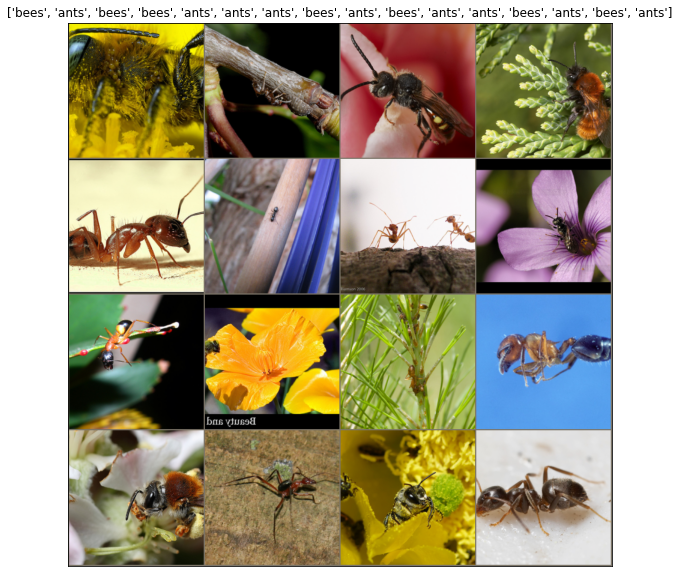

In [5]:
import torchvision

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
    """テンソル用のImshow"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(inp)
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
        ax.set_title(title)

# 訓練用データのバッチを取得
inputs, classes = next(iter(dataloaders['train']))

# バッチからグリッドを作成
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes], ax=ax)

### モデル訓練用の補助関数

下記の関数はモデルを訓練する上で汎用的に使えるものです。
また、この関数では以下の処理も行っています。
- 学習率のスケジューリング
- 最良のモデルの保存

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
    """
    モデル訓練用の補助関数

    Args:
    model: 訓練されるモデル
    criterion: 最適化する基準（損失）
    optimizer: 訓練に使用するオプティマイザ
    scheduler: `torch.optim.lr_scheduler`のインスタンス
    num_epochs: epoch数
    device: 訓練を実行するデバイス（'cpu'または'cuda'を指定する必要があります。）
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 各エポックには訓練フェーズと検証フェーズが存在します。
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # モデルを訓練モードに設定
            else:
                model.eval()   # モデルを検証モードに設定

            running_loss = 0.0
            running_corrects = 0

            # データに対して反復
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # パラメーターの勾配のゼロ化
                optimizer.zero_grad()

                # フォワード
                # 訓練時のみ勾配の履歴を追跡
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 訓練フェーズの場合のみバックワード + 最適化を実行
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 統計量
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # モデルをディープコピー
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 最良のモデルの重みを読み込み
    model.load_state_dict(best_model_wts)
    return model

### モデルによる予測の可視化用の補助関数

画像に対する予測を表示するための汎用的な関数です。

In [7]:
def visualize_model(model, rows=3, cols=3):
    was_training = model.training
    model.eval()
    current_row = current_col = 0
    fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

    with torch.no_grad():
        for idx, (imgs, lbls) in enumerate(dataloaders['val']):
            imgs = imgs.cpu()
            lbls = lbls.cpu()

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            for jdx in range(imgs.size()[0]):
                imshow(imgs.data[jdx], ax=ax[current_row, current_col])
                ax[current_row, current_col].axis('off')
                ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds[jdx]]))

                current_col += 1
                if current_col >= cols:
                    current_row += 1
                    current_col = 0
                if current_row >= rows:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Part 1. 量子化済み特徴量抽出器を基にしたカスタム分類器の訓練

本セクションでは、**"フリーズされた"**量子化済み特徴量抽出器を使用し、特徴量抽出器の後に用意された、オリジナルの分類層（ヘッド部分）を訓練します。

浮動小数点モデルとは異なり、量子化済みモデルでは訓練可能なパラメータが存在しないため、`requires_grad=False`と設定する必要はありません。

詳細は[ドキュメンテーション](https://pytorch.org/docs/stable/quantization.html)をご確認ください。

事前訓練済みモデルを読み込みます。本チュートリアルでは、[ResNet-18](https://pytorch.org/hub/pytorch_vision_resnet/)を使用します。

In [8]:
import torchvision.models.quantization as models

# 後で使用するために、`fc`内のフィルタ数を取得しておく必要があります。
# ここでは、各出力サンプルのサイズは2に設定しておきます。
# なお代わりに、nn.Linear(num_ftrs, len(class_names))として一般化しておくことも可能です。
model_fe = models.resnet18(pretrained=True, progress=True, quantize=True)
num_ftrs = model_fe.fc.in_features

/usr/local/lib/python3.7/dist-packages/torch/quantization/observer.py:121: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."
Downloading: "https://download.pytorch.org/models/quantized/resnet18_fbgemm_16fa66dd.pth" to /root/.cache/torch/hub/checkpoints/resnet18_fbgemm_16fa66dd.pth


ここで、事前訓練済みモデルに手を加える必要があります。

モデルには、最初と最後の部分に量子化/逆量子化ブロックが存在します。

しかし、今回は特徴量抽出器のみ使用するため、逆量子化層は線形層（ヘッド）の直前に移動する必要があります。

逆量子化層を最も簡単な方法で移動するには、モデルを`nn.Sequential`モジュール内にラップします。

最初の手順として、ResNetモデル内の特徴量抽出器を独立化します。

なお、本チュートリアルでは、特徴量抽出器として`fc`を除くすべての層を使用することにしていますが、実際は必要な部分のみを使用することも可能です。

畳み込み層の一部も置換したい場合にこのテクニックが役に立つでしょう。

**注釈**

特徴量抽出器と量子化済みモデル内のそれ以外の部分を分離する際には、量子化しておきたい部分の先頭と末尾に、手動で量子化器/逆量子化器を配置する必要があります。

下記の関数はオリジナルのヘッドを備えたモデルを作成します。

In [9]:
from torch import nn

def create_combined_model(model_fe):
    # Step 1. 特徴量抽出器の独立化
    model_fe_features = nn.Sequential(
        model_fe.quant,  # 入力の量子化
        model_fe.conv1,
        model_fe.bn1,
        model_fe.relu,
        model_fe.maxpool,
        model_fe.layer1,
        model_fe.layer2,
        model_fe.layer3,
        model_fe.layer4,
        model_fe.avgpool,
        model_fe.dequant,  # 出力の逆量子化
    )

    # Step 2. 新たな"head"の作成
    new_head = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, 2),
    )

    # Step 3. 結合（量子スタブを忘れずに）
    new_model = nn.Sequential(
        model_fe_features,
        nn.Flatten(1),
        new_head,
    )
    return new_model

**注意**

現時点で、量子化済みモデルはCPU上でのみ実行可能です。
しかし、モデル内の量子化済みでない部分についてはGPUに送信することができます。

In [10]:
import torch.optim as optim
new_model = create_combined_model(model_fe)
new_model = new_model.to('cpu')

criterion = nn.CrossEntropyLoss()

# ヘッドのみ訓練することに留意
optimizer_ft = optim.SGD(new_model.parameters(), lr=0.01, momentum=0.9)

# 7エポック毎に0.1ずつ学習率を減衰させる。
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 訓練と評価

この工程はCPUで約15分-25分かかります（Google Colab上では7分ほどでした）。

量子化済みモデルはCPU上でのみ実行可能であるため、GPU上での訓練は行なえません。

Epoch 0/24
----------
train Loss: 0.6451 Acc: 0.7336
val Loss: 0.3700 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4943 Acc: 0.8852
val Loss: 0.3715 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.3926 Acc: 0.9344
val Loss: 0.4469 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.3145 Acc: 0.9385
val Loss: 0.4023 Acc: 0.9608

Epoch 4/24
----------
train Loss: 0.3177 Acc: 0.9180
val Loss: 0.3269 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.2252 Acc: 0.9385
val Loss: 0.4215 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4762 Acc: 0.9180
val Loss: 0.4245 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.2845 Acc: 0.9344
val Loss: 0.4165 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.2661 Acc: 0.9549
val Loss: 0.4503 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3633 Acc: 0.9303
val Loss: 0.4807 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2480 Acc: 0.9344
val Loss: 0.4200 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.1931 Acc: 0.9426
val Loss: 0.3992 Acc: 0.9608

Ep

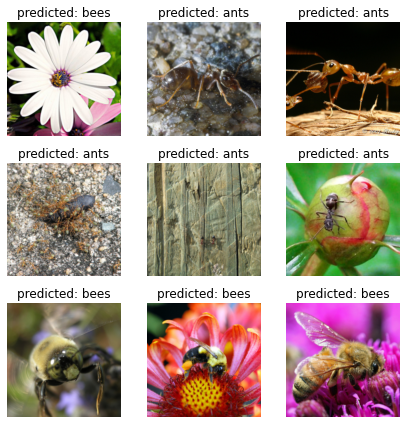

In [11]:
new_model = train_model(new_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=25, device='cpu')

visualize_model(new_model)
plt.tight_layout()

## Part 2. 量子化済みモデルのファインチューニング

本パートでは、転移学習に用いる特徴量抽出器をファインチューンし、特徴量抽出器を量子化します。

パート1とパート2ともに、特徴量抽出器は量子化されている点に留意してください。

パート1との違いは、パート1では事前訓練済みの量子化済みモデルを使用していた点です。

本パートでは、関心のあるデータセットに対してファインチューニングした後、量子化済み特徴量抽出器を作成します。

これは、転移学習により優れた精度を獲得した上で、量子化の利点を享受する手法と言えます。 

なお今回の具体例では、訓練用セットが非常に小さいため（120枚の画像）、モデル全体をファインチューニングした際に得られる利点が不明瞭になってしまっている点には留意してください。

しかし、ここで示す手順により、より大きなデータセットを用いた転移学習の精度は向上します。

事前訓練済みの特徴量抽出器は量子化可能である必要があります。

量子化可能であることを確認するために、以下の工程を踏みます。

1. `torch.quantization.fuse_modules`を使用し、(`Conv`, `BN`, `ReLU`)、(`Conv`, `BN`)、及び(`Conv`, `ReLU`)を融合します。
2. 特徴量抽出器をオリジナルのヘッドと接続します。これには特徴量抽出器の出力を逆量子化する必要があります。
3. 特徴量抽出器内の適切な位置に擬似量子化モジュールを挿入し、訓練中の量子化を模倣します。

工程（1）では、メソッドとして`fuse_model`を持つ`torchvision/models/quantization`のモデルを使用します。
この関数は、すべての`conv`、`bn`、そして`relu`モジュールを融合します。
カスタムモジュールについては、融合するモジュールのリストを手作業で作成し、`torch.quantization.fuse_modules` APIを呼び出す必要があります。

工程（2）は、前のセクションで使用された`create_combined_model`関数で処理します。

工程（3）は、`torch.quantization.prepare_qat`を使用し、疑似量子化モジュールを挿入することで実現します。

その後、

工程（4）として、モデルを"ファインチューニング"することから始め、その後で量子化済みのバージョンへと変換します。（工程5）

ファインチューニングされたモデルを量子化済みモデルに変換するには、`torch.quantization.convert`関数を呼び出します（今回のケースでは、特徴量抽出器のみが量子化されます。）。

**注釈**

初期化処理のランダム性により、本チュートリアル内で示されている結果とは異なる結果になる可能性があります。

In [12]:
# 注記
quantize=False 
model = models.resnet18(pretrained=True, progress=True, quantize=False)
num_ftrs = model.fc.in_features

# 工程1 
model.train() 
model.fuse_model() 

# 工程2 
model_ft = create_combined_model(model) 
model_ft[0].qconfig = torch.quantization.default_qat_qconfig # デフォルトのQATの設定を使用 

# 工程3 
model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.7/dist-packages/torch/quantization/observer.py:121: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."


### モデルのファインチューニング

今回のチュートリアルでは、モデル全体をファインチューニングしています。

一般的には、モデル全体をファインチューニングすることでより高い精度の実現に繋がります。

しかし、今回は訓練用セットが小さいため、結果的には訓練用セットにオーバーフィット（過学習）してしまいます。



工程4 モデルのファインチューン

In [13]:
print(device)

cuda:0


In [14]:
for param in model_ft.parameters():
    param.requires_grad = True

model_ft.to(device)  # GPUが利用可能であればGPU上でファインチューンが可能です。

criterion = nn.CrossEntropyLoss()

# すべてを訓練するため、学習率を低めに設定している点に留意してください。
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

# 数エポック毎に0.3ずつ学習率を減衰させます。
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.3)

model_ft_tuned = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                             num_epochs=25, device=device)

Epoch 0/24
----------
train Loss: 0.6184 Acc: 0.6885
val Loss: 0.3469 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.3012 Acc: 0.8852
val Loss: 0.2064 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.1994 Acc: 0.9467
val Loss: 0.1742 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.1510 Acc: 0.9467
val Loss: 0.1747 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.1531 Acc: 0.9467
val Loss: 0.2016 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.0952 Acc: 0.9631
val Loss: 0.1923 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.0755 Acc: 0.9836
val Loss: 0.1704 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.0856 Acc: 0.9631
val Loss: 0.1740 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.0556 Acc: 0.9877
val Loss: 0.1716 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.0936 Acc: 0.9672
val Loss: 0.1718 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.1342 Acc: 0.9508
val Loss: 0.1688 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.0606 Acc: 0.9959
val Loss: 0.1701 Acc: 0.9477

Ep

工程5 量子化済みモデルへの変換

In [15]:
from torch.quantization import convert
model_ft_tuned.cpu()

model_quantized_and_trained = convert(model_ft_tuned, inplace=False)

量子化済みモデルがどのように振る舞うか、数枚の画像に対して確認してみましょう。

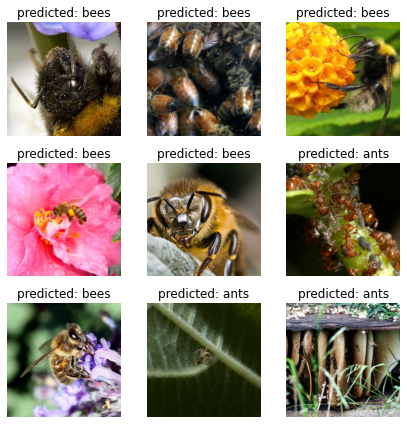

In [16]:
visualize_model(model_quantized_and_trained)

plt.ioff()
plt.tight_layout()
plt.show()

以上。
